In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

number_of_videos = 5

data = np.load('data/MOVIE/videos/0.npy')
print("Datashape: " + str(data.shape))

Datashape: (24, 128, 128, 3)


K-Means Clustering on Pixel based on color doesnt work

X, Y, R, G, B
[[ 96.74274611  96.50544041  21.89867876  17.5661658   18.64531088]
 [ 31.14129643  20.17880554  19.37840495  16.84468318  15.53761835]
 [ 96.828593    31.68537629  22.2171407   18.83966776  18.27326957]
 [ 30.99401619 105.86659627  19.11309398  15.17793031  14.04540655]
 [ 36.6697031   62.68859649  25.79827935  21.28836032  20.50951417]]


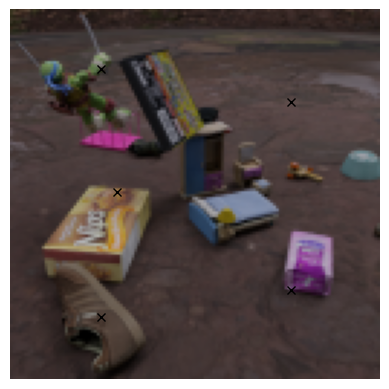

In [2]:
import math
from sklearn.cluster import KMeans

%matplotlib inline

def cluter_points(data, num_clusters, color_scaling=1, dist_scaling=1, height=128, width=128):
    posarr = np.zeros((128,128,2))

    for h in range(height):
        for w in range(width):
            posarr[h][w][0] = w
            posarr[h][w][1] = h
    

    posarr = posarr * dist_scaling
    data = data * color_scaling

    points = np.concatenate((posarr,data), axis=2).reshape(height*width, 5)
    k_mean = KMeans(n_clusters=num_clusters, init="k-means++", ).fit(points)

    print("X, Y, R, G, B")
    print(k_mean.cluster_centers_)

    clusters = np.delete(k_mean.cluster_centers_, [2,3,4], 1)

    return clusters

def display_clusterpoints( data, clusters, ax):
    ax.imshow(data)

    for cluster in clusters:
        ax.plot(cluster[0], cluster[1], marker="x", color="blacK")
        ax.axis('off')


clusters = cluter_points(data[0], 5, color_scaling=0.3)
display_clusterpoints(data[0], clusters, plt.gca())

Slow flooding
- Place clusters all over the image
- Calculate a mean and a std of cluster (global and local)
- have some unite parameters that rises slowly, once neighboring pixel/clusters get to close, they get united

0.03978659940916551
0.02061156474669475


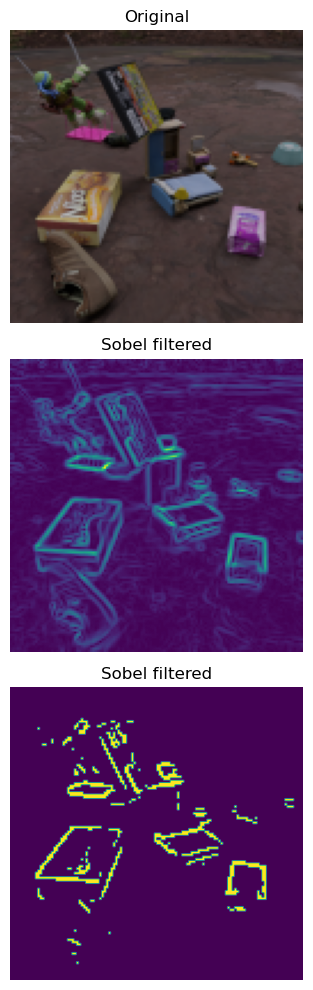

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, color, morphology
from skimage.segmentation import flood, flood_fill


data = np.load('data/MOVIE/videos/0.npy')

point = (64,64)
im = data[0].copy()
im_sobel = filters.sobel(data[0][..., 0])

fig, ax = plt.subplots(nrows=3, figsize=(5, 10))

ax[0].imshow(im)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(im_sobel)
ax[1].set_title('Sobel filtered')
ax[1].axis('off')


print(im_sobel.mean())
print(np.median(im_sobel))

ax[2].imshow(im_sobel>0.15)
ax[2].set_title('Sobel filtered')
ax[2].axis('off')

fig.tight_layout()
plt.show()

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

rand = (8318,  95146, 176100)

for x in range(number_of_videos):
    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')
    data2 = np.load('data/MOVIE/segmentations/'+str(x)+'.npy')

    frameSize = (data.shape[1], data.shape[2])
    filename = "videos/"+str(x)+"_default_video.mp4"
    out = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
    filename = "videos/"+str(x)+"_annotations.mp4"
    out2 = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for x,y in zip(data,data2):
        out.write(x)

        
        
        mask = np.stack((y.copy()*rand[0], y.copy()*rand[1], y.copy()*rand[2]), 2).astype(np.uint8).squeeze()
        out2.write(mask)
        

    out.release()

# Dense optical Flow

In [5]:

for x in range(number_of_videos):
    cap = cv2.VideoCapture("videos/"+str(x)+"_default_video.mp4")

    ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    i = 0

    frameSize = (int(cap.get(3)), int(cap.get(4)))

    name = 'videos/'+str(x)+'_dense_flow_mask.mp4'
    hsv_vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    while(1):
        ret, frame2 = cap.read()

        if not ret:
            break

        next = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)
        
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

        hsv_vid.write(rgb)
        
        prvs = next
        i+=1

    hsv_vid.release()
    cap.release()


# Sparse optical flow 

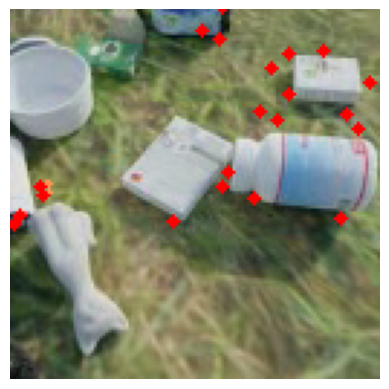

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

for x in range(number_of_videos):
    cap = cv2.VideoCapture("videos/"+str(x)+"_default_video.mp4")

    frameSize = (int(cap.get(3)), int(cap.get(4)))

    name = 'videos/'+str(x)+'_sparse_flow_mask.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)


    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                    maxLevel = 2,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0,255,(100,3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_RGB2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)


    while(1):
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)

        ret,frame = cap.read()

        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel().astype(int)
            c,d = old.ravel().astype(int)

            mask = cv2.line(mask, (a,b),(c,d), (255, 0, 0) , 2)
            frame = cv2.circle(frame,(a,b),2, (255, 0, 0) ,-1)
        
        img = cv2.add(frame,mask)
        vid.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        # Now update the previous frame and previous points
        old_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        p0 = good_new.reshape(-1,1,2)

    vid.release()
    cap.release()

    plt.imshow(img)
    plt.axis("off")

# Shi Tomasi Feature Tracking Parameter Testing

/tmp/ipykernel_1895972/1319758502.py:19: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


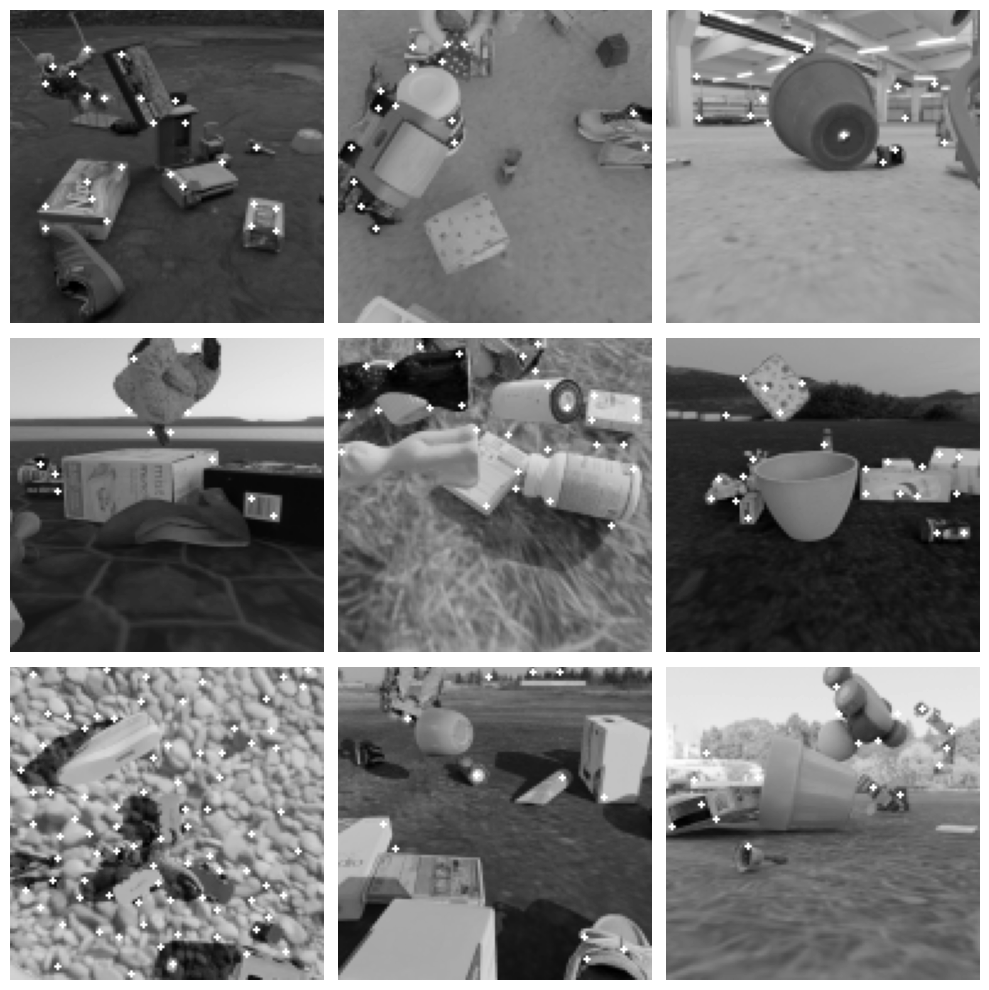

In [16]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))

feature_params = dict( maxCorners = 100,
                    qualityLevel = 0.3,
                    minDistance = 7,
                    blockSize = 7 )

for i in range(9):
    a = i%3
    b = int(i/3)

    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    img = data[0]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
 
    corners = cv2.goodFeaturesToTrack(gray,mask = None,**feature_params)

    corners = np.int0(corners)
 
    for ii in corners:
        x,y = ii.ravel()
        cv2.circle(gray,(x,y),1,255,-1)

    ax[a][b].imshow(gray, cmap='gray')
    ax[a][b].axis('off')

fig.tight_layout()
plt.show()
 


# Segment Anything

In [63]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

In [69]:
image = np.load('data/MOVIE/videos/0.npy')[0]

import sys
sys.path.append("..")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "model/vit_b.pth"
model_type = "vit_b"

torch.cuda.set_device(7)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)

KeyboardInterrupt: 

# NEXT STEP, CREATE VIDEO OF THE SEGMENTATIONS BY SAM

68
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


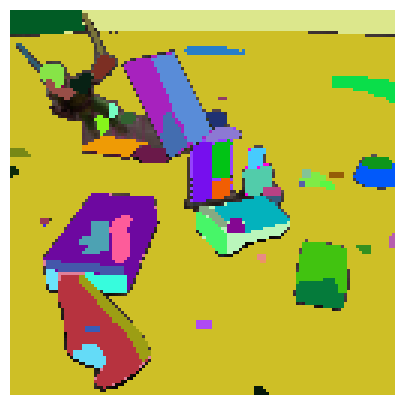

In [65]:
masks = mask_generator.generate(image)

print(len(masks))
print(masks[0].keys())

plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 


In [66]:
import numpy as np
import cv2

extracted_features = 10

list_of_colors = [np.random.random(3) for x in range(extracted_features)] 


for i in range(number_of_videos):
    print(i)
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    name = 'videos/'+str(i)+'_sam_at_'+str(extracted_features)+'_features.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
    name = 'videos/'+str(i)+'_sam_background_reduction.mp4'
    vid2 = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
     
    for im in image:
        bw_im = cv2.cvtColor(cv2.cvtColor(im.copy(),cv2.COLOR_RGB2GRAY),cv2.COLOR_GRAY2RGB)
                             
        masks = mask_generator.generate(im.copy())

        # find background mask
        max_i = 0
        max = 0
        for j,mask in enumerate(masks):
            if mask["area"] > max:
                max = mask["area"]
                max_i = j
        
        bg = im.copy()
        largest_mask = masks[max_i]["segmentation"]
        
        mask = np.stack((np.zeros(largest_mask.shape).astype(bool), np.zeros(largest_mask.shape).astype(bool), largest_mask.copy()), 2)
        bg[mask] = 255
        vid2.write(bg)

        # extract x masks
        extracted_masks = []

        for i,x in enumerate(masks):
            extracted_masks.append(x)
            if i == extracted_features:
                break

        for x in extracted_masks:
            mask = x["segmentation"]
            
            mask = np.stack((np.zeros(mask.shape).astype(bool), np.zeros(mask.shape).astype(bool), mask.copy()), 2)
            im[mask] = 255
        
        vid.write(im)
    
    vid.release()
    vid2.release()


0


1
2
3
4


# Test YOLO

In [3]:
import torch

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_yolo_mask(raw_image, masks):
    fig, axes = plt.subplots(1, 1, figsize=(15, 15))
    axes.imshow(np.array(raw_image))
    axes.axis("off")

    for mask in masks:
      show_box( [mask[0],mask[1],mask[2],mask[3]], axes)
    plt.show()

def yolo_eval_batch( model, batch, threshhold ):
    res = []
    
    for x in batch:
        t = model(x).xyxy[0].to("cpu").numpy()
        res.append( t )
    # structure xmin, ymin, xmax, ymax, confidence, type
    return res


# Define Yolo

print(torch.cuda.is_available())
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', device="cpu", pretrained=True, _verbose=False)
torch.cuda.set_device(4)
model.to("cuda")

True


Using cache found in /user/georg.eckardt/.cache/torch/hub/ultralytics_yolov5_master


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

In [68]:
%matplotlib inline

for x in range(number_of_videos):
    name = 'videos/'+str(x)+'_yolo_mask.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)
    
    data = np.load('data/MOVIE/videos/'+str(x)+'.npy')

    masks = yolo_eval_batch( model, data, 0 )

    for image,mask in zip(data,masks):
        img = image.copy()
        for box in mask:
            img = cv2.rectangle(img, ( int(box[0]), int(box[1])), ( int(box[2]), int(box[3])), (255, 255, 255) , 2)
        vid.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    vid.release()    

# Segemention (connected compontents + multi-Otsu threshold )

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from skimage.filters import threshold_multiotsu
import skimage

rand = (np.random.rand(3)*100)
rand[0] *= 100
rand[1] *= 1000
rand[2] *= 10000
rand = rand.astype(int)
print(rand)

rand = (8318,  95146, 176100)

for num_class in (2,3,4,5):
    for i in range(number_of_videos):
        image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

        name = 'videos/'+str(num_class)+"_"+str(i)+'otsu.mp4'
        vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

        for x in image:
            im = x
            im = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2GRAY)


            thresholds = threshold_multiotsu(im, classes=num_class)
            regions = np.digitize(im, bins=thresholds).astype(np.uint8)
            regions = skimage.morphology.label(regions,2)

            regs_random = np.stack((regions.copy()*rand[0], regions.copy()*rand[1], regions.copy()*rand[2]), 2).astype(np.uint8)
            regs_random = cv2.cvtColor(regs_random.copy(),cv2.COLOR_HSV2RGB)
            
            vid.write(regs_random)
        vid.release()


[  6090  40149 679860]


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import cv2
from skimage.filters import threshold_multiotsu
import skimage
from skimage.segmentation import chan_vese

%matplotlib inline

rand = (np.random.rand(3)*100)
rand[0] *= 100
rand[1] *= 1000
rand[2] *= 10000
rand = rand.astype(int)
print(rand)

rand = (8318,  95146, 176100)

for i in range(number_of_videos):
    image = np.load('data/MOVIE/videos/'+str(i)+'.npy')

    name = 'videos/'+str(i)+'chan_vese.mp4'
    vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

    for x in image:
        im = x
        im = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2HSV)

        cv = chan_vese(
                cv2.cvtColor(x.copy(),cv2.COLOR_RGB2GRAY),
                mu=0.1,
                lambda1=1,
                lambda2=1,
                tol=1e-5,
                max_num_iter=200,
                dt=0.5,
                init_level_set="checkerboard",
        )

        im = np.stack((cv.copy()*255, cv.copy()*128, cv.copy()*25), 2).astype(np.uint8)
        
        vid.write(im)
    vid.release()


[  5832  91888 626179]


# Sam with sparse flow points

In [15]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2

sam_checkpoint = "model/vit_b.pth"
model_type = "vit_b"

torch.cuda.set_device(7)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")

predictor = SamPredictor(sam)

In [17]:
i = 0
frameSize = (128,128)

data = np.load('data/MOVIE/videos/'+str(i)+'.npy')

feature_params = dict( maxCorners = 100,
                    qualityLevel = 0.2,
                    minDistance = 5,
                    blockSize = 5 )


name = 'videos/'+str(i)+'sam_with_sparse_flow.mp4'
vid = cv2.VideoWriter(name,cv2.VideoWriter_fourcc(*'mp4v'), 12, frameSize)

for frame in data:
    img = frame
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,mask = None,**feature_params)
    
    predictor.set_image(img)
    masks, scores, logits = predictor.predict( point_coords=corners, point_labels=np.ones(corners.shape[0]), multimask_output=True )
    print(masks.shape)
    print(scores.shape)
    print(logits.shape)
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 7 has a total capacity of 10.75 GiB of which 745.56 MiB is free. Process 887664 has 8.15 GiB memory in use. Including non-PyTorch memory, this process has 1.86 GiB memory in use. Of the allocated memory 1.56 GiB is allocated by PyTorch, and 116.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)